<a href="https://colab.research.google.com/github/KrishnaRaheja/Forecasting-SeaTac-Airport-Traffic-with-SARIMA/blob/main/Forecasting%20SeaTac%20Airport%20Traffic%20with%20SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
If facing issues with pmdarima, what worked for me was:

Step 1: Uninstall both numpy and pmdarima
!pip uninstall -y numpy pmdarima

Step 2: Reinstall a compatible version of numpy and pmdarima
!pip install numpy==1.23.5
!pip install pmdarima --no-cache-dir

Then rerun the entire program

"""

# For fixing issues with pmdarima version compatibility
!pip uninstall -y numpy pmdarima
!pip install numpy==1.23.5
!pip install pmdarima --no-cache-dir

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requ

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.2 MB/s eta 0:00:00


In [ ]:
!pip3 install pmdarima

^C


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

'\nIf facing issues with pmdarima, what worked for me was:\n\nStep 1: Uninstall both numpy and pmdarima\n!pip uninstall -y numpy pmdarima\n\nStep 2: Reinstall a compatible version of numpy and pmdarima\n!pip install numpy==1.23.5\n!pip install pmdarima --no-cache-dir\n\nThen rerun the entire program\n\n'

**DATA PREPARATION**

In [ ]:
# Getting CSV data file from user
from google.colab import files
uploaded = files.upload()

# Loading files into dataframe df
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

Saving TOTAL 2003.2024 (Departures, Arrivals).csv to TOTAL 2003.2024 (Departures, Arrivals).csv


In [ ]:
# Converting dates to datetime (Pandas sometimes reads these as strings by default)
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index("Date", inplace=True)

# Sort the index (just in case)
df = df.sort_index()

# Convert Passengers column to numeric (Pandas sometimes reads these as strings by default)
df["Passengers"] = pd.to_numeric(df["Passengers"], errors="coerce")

In [ ]:
# Checking to see if data is right....

print(df.head(3))
print("....................................")
print(df.tail(3))
print()

print(f"(rows, columns): {df.shape}")

            Year  Month  Passengers
Date                               
2003-01-01  2003      1     1792044
2003-02-01  2003      2     1701196
2003-03-01  2003      3     1988723
....................................
            Year  Month  Passengers
Date                               
2024-10-01  2024     10     4257406
2024-11-01  2024     11     3709457
2024-12-01  2024     12     4083167

(rows, columns): (264, 3)


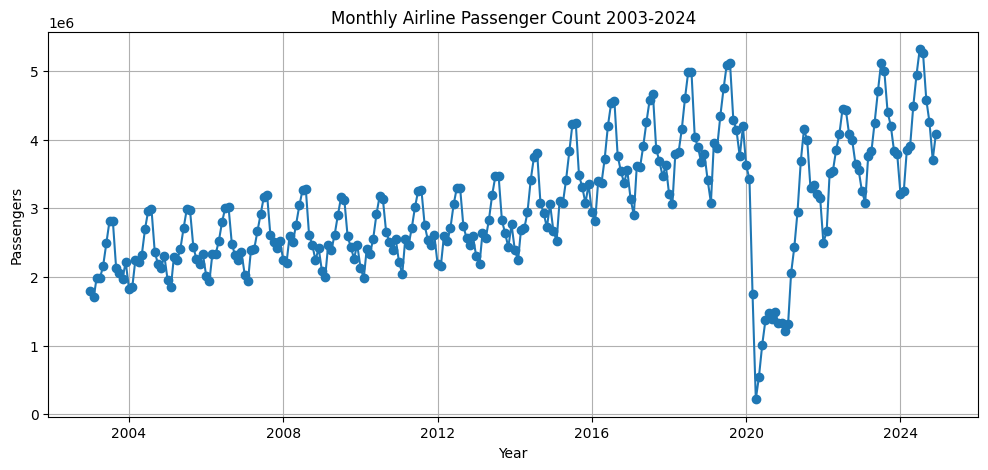

In [ ]:
# Plotting the raw time series data
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Passengers'], marker='o', linestyle='-')

plt.title("Monthly Airline Passenger Count 2003-2024")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.grid()
plt.show()

As observed in the data, there is a clear dip in passenger count during the COVID years. This dip recovers by 2023 to pre-covid levels where passenger counts were in 2019. For the sake of forecasting, we should filter the data to pre-covid levels and address potential impacts of COVID on future passenger counts later on.

In [ ]:
# Creating df_filtered as a copy of df, without .copy() we would be using a refrence of the original dataaset and messing with that is risky
df_filtered = df[(df['Year'] >= 2003) & (df['Year'] <= 2019)].copy()

# Remove any possible NaN values after conversion
df_filtered = df_filtered.dropna()

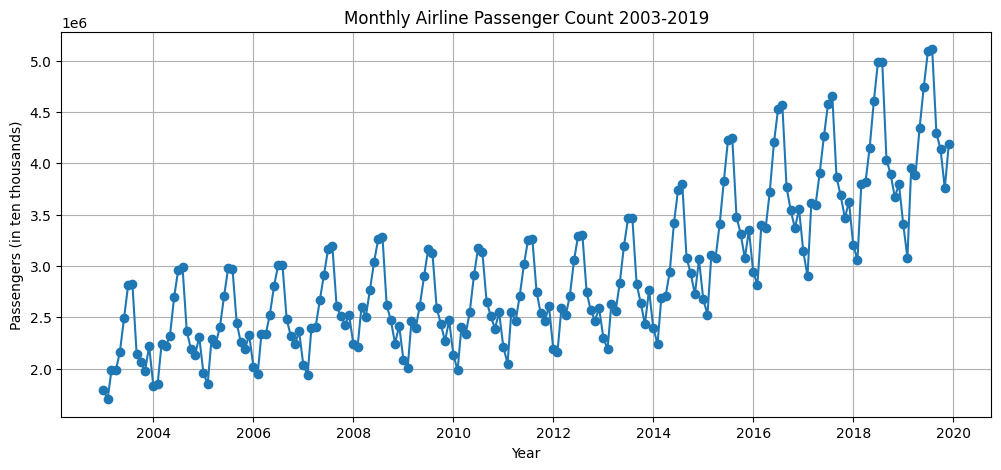


Printing the last three rows to confirm the data ends in 2019:
            Year  Month  Passengers
Date                               
2019-10-01  2019     10     4137714
2019-11-01  2019     11     3755736
2019-12-01  2019     12     4192384


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_filtered.index, df_filtered["Passengers"], marker='o', linestyle='-')
plt.title('Monthly Airline Passenger Count 2003-2019')
plt.xlabel('Year')
plt.ylabel('Passengers (in ten thousands)')
plt.grid()
plt.show()

# Confirming the data filtering
print('')
print('Printing the last three rows to confirm the data ends in 2019:')
print(df_filtered.tail(3))

**STATIONARY TEST USING ADF HYPOTHESIS TEST**

In [ ]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(df_filtered['Passengers'])

ADF Statistic: 1.1713617578230338
p-value: 0.9957819227619469
Non-Stationary


We have Non-Stationary data, so we must transform our data to stationary data.
Stationarity is a fundamental assumption for numerous time series models such as ARIMA (Auto Regression Integrated Moving Average) and SARIMA (Seasonal ARIMA).
We will do this by adjusting the Differencing component of SARIMA (parameters d, D) when applying SARIMAX to our data.

**SETTING UP SARIMA PARAMETERS**

In [ ]:
# Using the filtered 2003–2019 data, automatically search for best SARIMA params by comparing AIC of models (using auto_arima from pmdarima)
stepwise_model = auto_arima(df_filtered['Passengers'],
                            start_p=0, start_q=0,
                            max_p=3, max_q=3,
                            start_P=0, start_Q=0,
                            max_P=2, max_Q=2,
                            d=1, D=1,        # Assume we'll difference once for trend and once for seasonality
                            seasonal=True,
                            m=12,            # Monthly seasonality
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4790.870, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4781.615, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4780.442, Time=0.51 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4781.427, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4779.841, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4780.680, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4781.320, Time=2.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4781.366, Time=1.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4780.025, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4780.502, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=7.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AIC=4788.007, Time=0.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4780.357, Time=1.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[12]             : AIC=4779.594, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=4780.233, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,0)[12]             : AIC=4780.528, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,1)[12]             : AIC=4781.146, Time=1.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,2)[12]             : AIC=4781.191, Time=3.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,0)[12]             : AIC=4781.801, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[12]             : AIC=4779.813, Time=0.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,0)[12]             : AIC=4780.323, Time=0.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,2)[12]             : AIC=4780.378, Time=4.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[12]             : AIC=4781.687, Time=1.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,1,1)[12]             : AIC=4781.536, Time=1.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,1,1)[12]             : AIC=4780.194, Time=4.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[12] intercept   : AIC=4782.044, Time=0.87 sec

Best model:  ARIMA(0,1,2)(1,1,1)[12]          
Total fit time: 39.644 seconds


**APPLYING DATA TO SARIMA & FORECASTING**

In [ ]:
# Extracting best SARIMA order
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order

print("Best Order (p, d, q):", order)
print("Best Seasonal Order (P, D, Q, s):", seasonal_order)

# Printing summary of SARIMAX model fitted to our filtered dataframe
model = SARIMAX(df_filtered["Passengers"],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False) # allows model to freely explore more AR terms, allows model to use more past data when forecasting
                #enforce_invertibility=False)

results = model.fit()
print(results.summary())

Best Order (p, d, q): (0, 1, 2)
Best Seasonal Order (P, D, Q, s): (1, 1, 1, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  204
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -2189.783
Date:                              Thu, 05 Jun 2025   AIC                           4389.566
Time:                                      18:22:18   BIC                           4405.418
Sample:                                  01-01-2003   HQIC                          4395.996
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3381      0.069     -4.897      0.000      -0.473      -0.203
ma.L2          0.06

In [ ]:
steps = 12
forecast = results.get_forecast(steps=steps) # forecasts 12 months (each datapoint is a month, so 12 steps is 12 months)
mean_forecast = forecast.predicted_mean # extracts forecasted mean value for each of those steps (passenger count values)
conf_int = forecast.conf_int() # generates confidence interval for each forecasted value, each point has an upper and lower bound

# Creating new dates on x axis because our df_filtered stops at 2019, must add more dates to show the forecasted steps
forecast_index = pd.date_range(start=df_filtered.index[-1] + pd.DateOffset(months=1), # Takes last value of data in df_filtered (Dec 2019) and adds 1 to start forecasting in the next month (Jan 2020)
                               periods=steps, freq='MS')
# Assigns new time index to forecast and confidence interval
mean_forecast.index = forecast_index
conf_int.index = forecast_index

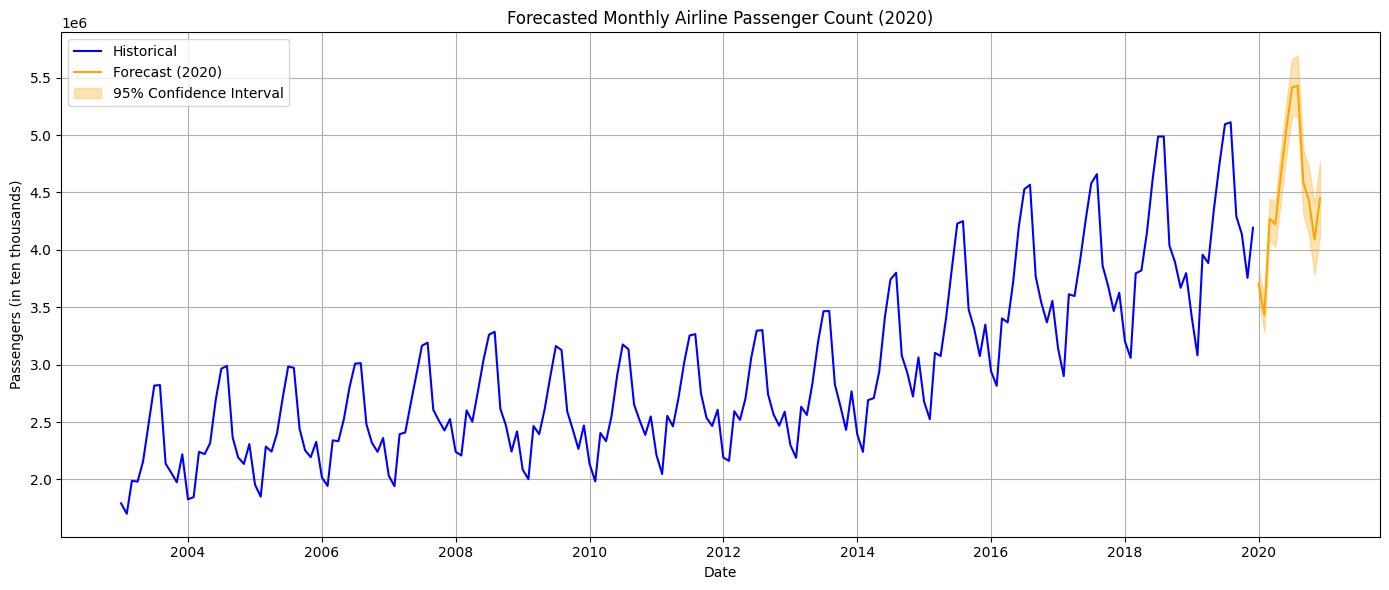

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_filtered.index, df_filtered["Passengers"], label="Historical", color="blue") # Historical data in blue
plt.plot(mean_forecast.index, mean_forecast, label="Forecast (2020)", color="orange") # Forecasted data in orange
plt.fill_between(mean_forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.3, label="95% Confidence Interval") # Shades lower and upper bounds of confidence interval for forecasted values

plt.title("Forecasted Monthly Airline Passenger Count (2020)")
plt.xlabel("Date")
plt.ylabel("Passengers (in ten thousands)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
steps = 60 # forecasting 60 months, which is 5 years
forecast = results.get_forecast(steps=steps) # forecasts 60 months (each datapoint is a month, so 60 steps is 60 months)
mean_forecast = forecast.predicted_mean # extracts forecasted mean value for each of those steps (passenger count values)
conf_int = forecast.conf_int() # generates confidence interval for each forecasted value, each point has an upper and lower bound

# Creating new dates on x axis because our df_filtered stops at 2019, must add more dates to show the forecasted steps
forecast_index = pd.date_range(start=df_filtered.index[-1] + pd.DateOffset(months=1), # Takes last value of data in df_filtered (Dec 2019) and adds 1 to start forecasting in the next month (Jan 2020)
                               periods=steps, freq='MS')
# Assigns new time index to forecast and confidence interval
mean_forecast.index = forecast_index
conf_int.index = forecast_index

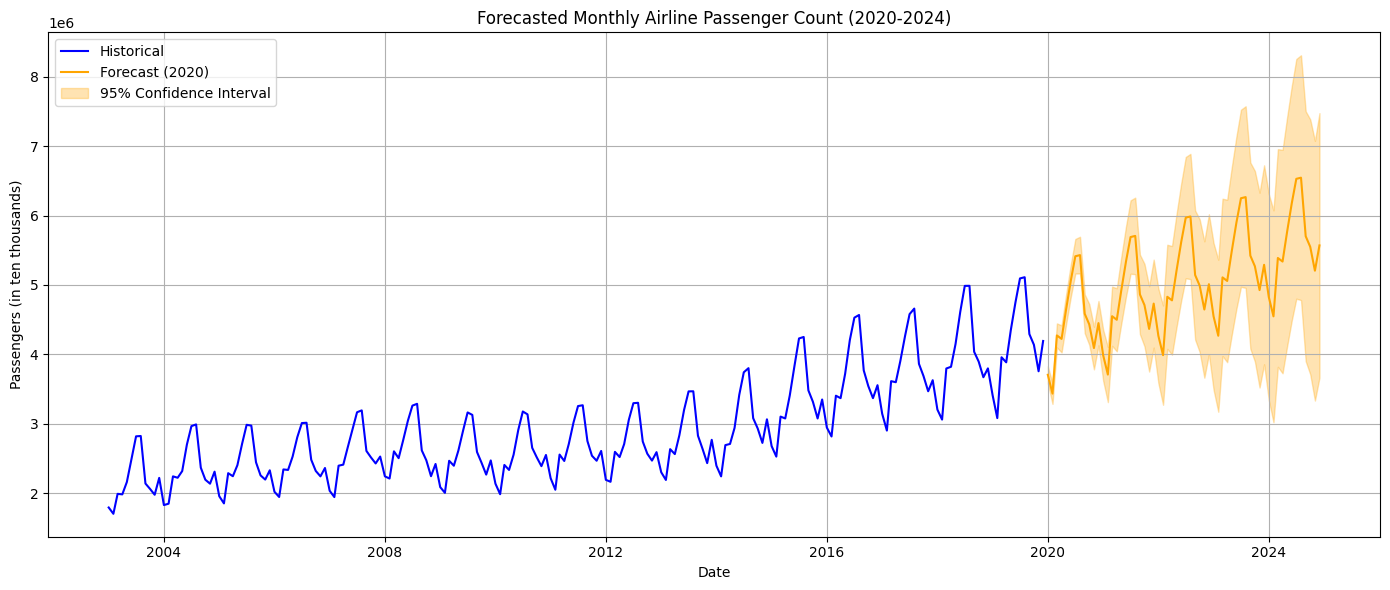

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_filtered.index, df_filtered["Passengers"], label="Historical", color="blue") # Historical data in blue
plt.plot(mean_forecast.index, mean_forecast, label="Forecast (2020)", color="orange") # Forecasted data in orange
plt.fill_between(mean_forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.3, label="95% Confidence Interval") # Shades lower and upper bounds of confidence interval for forecasted values

plt.title("Forecasted Monthly Airline Passenger Count (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Passengers (in ten thousands)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

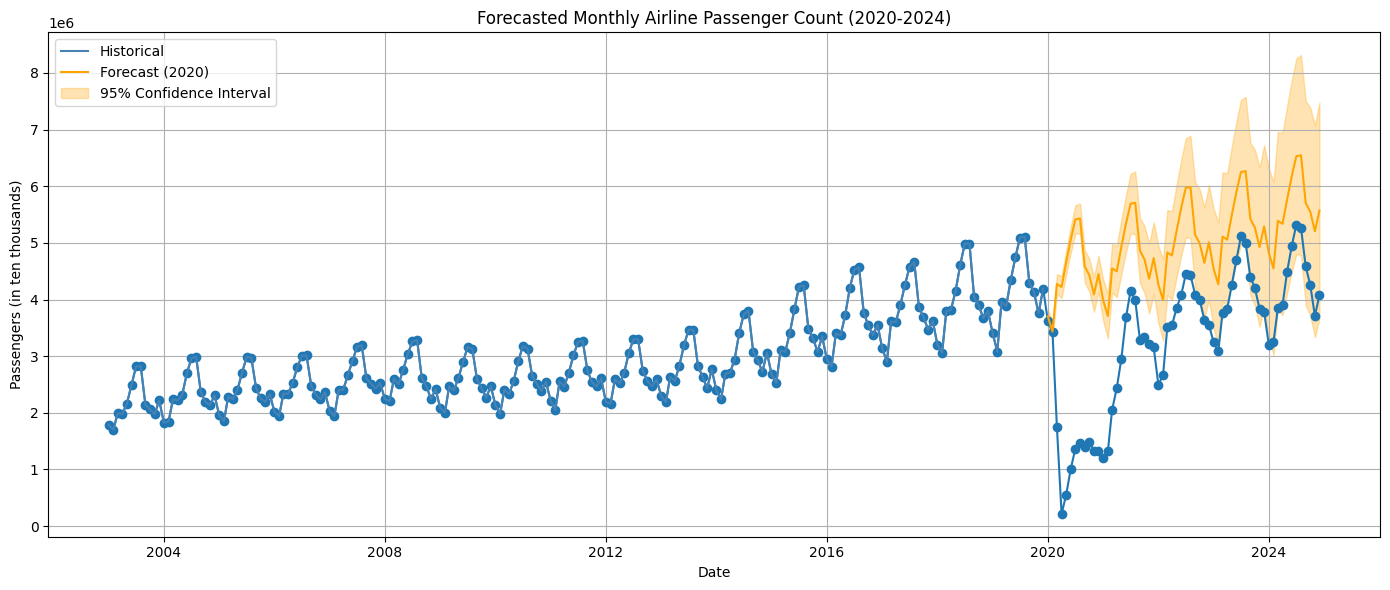

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Passengers'], marker='o', linestyle='-')
plt.plot(df_filtered.index, df_filtered["Passengers"], label="Historical", color="steelblue") # Historical data in blue
plt.plot(mean_forecast.index, mean_forecast, label="Forecast (2020)", color="orange") # Forecasted data in orange
plt.fill_between(mean_forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.3, label="95% Confidence Interval") # Shades lower and upper bounds of confidence interval for forecasted values

plt.title("Forecasted Monthly Airline Passenger Count (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Passengers (in ten thousands)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()